# Метрики качества кластеризации

Структура:  
1. Внутренние и внешние методы оценки качества кластеризации  
2. Практика  
    2.1 Коэффициент силуэта  
    2.2 Однородность и полнота  
    2.3 V-мера  
3. Кластеризация текстов

In [2]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score, v_measure_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn import metrics

# 1. Внутренние и внешние методы оценки качества кластеризации

Выделяют две большие группы методов:

- **Внутренние методы** — отображают качество кластеризации только по информации в данных.
- **Внешние методы** — основаны на сравнении результата кластеризации с априори известным разделением на классы.

## Внутренние методы

- **Среднее внутрикластерное расстояние** - насколько плотно друг к другу расположены точки. Значение данного функционала должно быть как можно меньше, чтобы объекты располагались как можно ближе друг к другу внутри кластера.   

- **Среднее межкластерное расстояние** - насколько далеко друг от друга находятся кластеры. Значение этого функционала должно быть как можно больше, чтобы объекты из разных кластеров находились друг от друга как можно дальше.  

**Можно оптимизирвоать отношение этих двух расстояний**. Необходимо, чтобы оно было минимально (это будет достигаться, если расстояние между кластерами максимально, а внутри кластера — минимально).  

- **Среднее расстояние от объктов до центра кластера** - должно быть как можно меньше, чтобы объекты располагались максимально близко к центру кластера.  

- **Сумма межкластерных расстояний** - расстояние от центра каждого кластера до центра выборки. Значение этого функционала должно быть максимальным, так как кластеры должны находиться друг от друга на как можно большем расстоянии. 

**Можно оптимизирвоать отношение этих двух расстояний**.

#### Коэффициент силуэта  
Коэффициент силуэта показывает, насколько объект похож на свой кластер по сравнению с другими кластерами. Его значение варьируется в диапазоне от -1 до +1. Если у подавляющего большинства объектов этот коэффициент высокий, то можно считать кластеризацию достаточно качественной. Если же у большого числа объектов низкий или отрицательный коэффициент силуэта, то, возможно, кластеров слишком много, мало или данные плохо поддаются разделению на кластеры.  
- a— среднее расстояние от данного объекта до объектов из того же кластера.
- b— среднее расстояние от данного объекта до объектов из ближайшего кластера.  
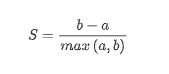

## Внешние методы

- **Однородность** — кластер состоит только из объектов одного класса. Максимальное значение однородность достигает в том случае, если в кластере объекты одного класса.  H(C|K) — энтропия класса при условии кластера, H(C)  — энтропия класса.
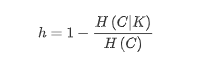  
- **Полнота** — достигает максимальное значение в том случае, когда все объекты из класса принадлежат одному кластеру.  
  H(K|C) — энтропия кластера при условии класса, H(K)  — энтропия кластера.   
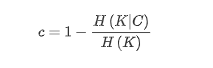
- **V-мера** — среднее гармоническое однородности и полноты, т.е. метрика, объединяющая эти два показателя.
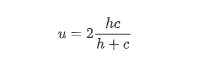

### Проверка наличия кластерной структуры (Статистика Хопкинса):
Прежде чем приступить к кластеризации данных необходимо убедиться, что выборка имеет кластерную структуру.  

- Генерируем ***p*** случайных точек из равномерного распределения.
- Генерируем ***p*** случайных точек из обучающей выборки.
- Вычисляем величину cтатистики Хопкинса.  

Если значение статистики Хопкинса близко к 0, то кластерная структура в наборе данных есть. Если значение статистики Хопкинса близко к 0.5, то кластерная структура в наборе данных отсутствует. Если статистика меньше чем 0.25, можно с 90% уверенностью можно сказать о наличии тенденции к группировке данных.
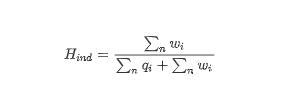

# 2. Практика  
## 2.1 Коэффициент силуэта (silhouette_score)

In [278]:
# Для последующих задач будем использовать сгенерированный датасет, содержащий два признака. В датасете три кластера.
n_samples = 1500
dataset = datasets.make_blobs(n_samples = n_samples, centers = 2, center_box = (-7.0, 7.5),
                              cluster_std = [1.4, 1.7],
                              random_state = 42)
X_2, _ = datasets.make_blobs(n_samples = n_samples, random_state = 170, centers = [[-4, -3]], cluster_std = [1.9])
transformation = [[1.2, -0.8], [-0.4, 1.7]]
X_2 = np.dot(X_2, transformation)
X, y = np.concatenate((dataset[0], X_2)), np.concatenate((dataset[1], np.array([2] * len(X_2))))

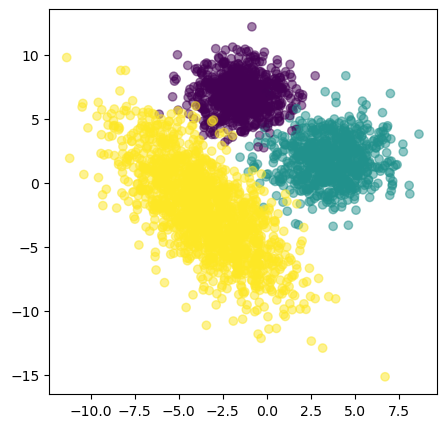

In [279]:
# Визуализируем датасет
plt.rcParams['figure.figsize'] = 5, 5
plt.scatter(X[:, 0], X[:, 1], c = y, alpha = 0.5)
plt.show()

#### Сравним результаты кластеризации четырёх алгоритмов на исходном датасете при помощи коэффициента силуэта. Посмотрим максимальное значение коэффициента силуэта, полученное при помощи данных моделей.  

Инициализируем алгоритмы со следующими параметрами:

- K-means — n_clusters=3, random_state=42
- EM-алгоритм (GaussianMixture) — n_components=3, random_state=42
- Агломеративная кластеризация – n_clusters=3
- DBSCAN – eps=0.9, min_samples=35


In [77]:
# k-means
km = KMeans(n_clusters = 3, random_state = 42).fit(X)
km_pred = km.labels_
silh_score_km = silhouette_score(X = X, labels = km_pred, metric = 'euclidean')
print(f'Коэффициент силуэта, полученный при помощи модели k-means: {silh_score_km:.2f}')

# GaussianMixture
gm = GaussianMixture(n_components = 3, random_state = 42)
gm_pred = gm.fit_predict(X)
silh_score_gm = silhouette_score(X = X, labels = gm_pred, metric = 'euclidean')
print(f'Коэффициент силуэта, полученный при помощи модели GaussianMixture: {silh_score_gm:.2f}')

# AgglomerativeClustering
ag = AgglomerativeClustering(n_clusters = 3).fit(X)
ag_pred = ag.labels_
silh_score_ag = silhouette_score(X = X, labels = ag_pred, metric = 'euclidean')
print(f'Коэффициент силуэта, полученный при помощи модели AgglomerativeClustering: {silh_score_ag:.2f}')

# DBSCAN
dbscan = DBSCAN(eps = 0.9, min_samples = 35).fit(X)
dbscan_pred = dbscan.labels_
silh_score_dbscan = silhouette_score(X = X, labels = dbscan_pred, metric = 'euclidean')
print(f'Коэффициент силуэта, полученный при помощи модели DBSCAN: {silh_score_dbscan:.2f}')

Коэффициент силуэта, полученный при помощи модели k-means: 0.51
Коэффициент силуэта, полученный при помощи модели GaussianMixture: 0.50
Коэффициент силуэта, полученный при помощи модели AgglomerativeClustering: 0.48
Коэффициент силуэта, полученный при помощи модели DBSCAN: 0.45


**Подберем оптимальное количество кластеров с помощью коэффициента силуэта**

- Для этого найдем такое число кластеров, при котором значение коэффициента будет максимальным.  
- В трёх из рассмотренных ранее алгоритмов зададим число кластеров при инициализации: K-means, EM-алгоритм и агломер. кластеризация.   
- Найдем значение коэффициента силуэта для данных алгоритмов при числе кластеров от 2 до 10 включительно при помощи цикла.

In [78]:
n_clausters = list(range(2, 11))
silh_score_dict = {}
for i in n_clausters:
    km = KMeans(n_clusters = i, random_state = 42).fit(X)
    km_pred = km.labels_
    silh_score_km = silhouette_score(X = X, labels = km_pred, metric = 'euclidean')
    silh_score_dict[i] = round(silh_score_km, 3)
print(f'k-means, кол-во кластеров = {max(silh_score_dict.items(), key = lambda x: x[1])[0]}, коэффициент силуэта: {max(silh_score_dict.items(), key = lambda x: x[1])[1]}')

silh_score_dict = {}
for i in n_clausters:
    gm = GaussianMixture(n_components=i, random_state=42).fit_predict(X)
    silh_score_gm = silhouette_score(X=X, labels=gm, metric='euclidean')
    silh_score_dict[i] = round(silh_score_gm, 3)
print(f'GaussianMixture, кол-во кластеров = {max(silh_score_dict.items(), key = lambda x: x[1])[0]}, коэффициент силуэта: {max(silh_score_dict.items(), key = lambda x: x[1])[1]}')
       
silh_score_dict = {}
for i in n_clausters:
    ag = AgglomerativeClustering(n_clusters=4).fit(X).labels_
    silh_score_ag = silhouette_score(X=X, labels=ag, metric='euclidean')
    silh_score_dict[i] = round(silh_score_ag, 3)
print(f'AgglomerativeClustering, кол-во кластеров = {max(silh_score_dict.items(), key = lambda x: x[1])[0]}, коэффициент силуэта: {max(silh_score_dict.items(), key = lambda x: x[1])[1]}')
       

k-means, кол-во кластеров = 3, коэффициент силуэта: 0.513
GaussianMixture, кол-во кластеров = 4, коэффициент силуэта: 0.511
AgglomerativeClustering, кол-во кластеров = 2, коэффициент силуэта: 0.485


## 2.2 Однородность (homogeneity_score) и  Полнота (completeness_score)

**Сравним результаты кластеризации алгоритмов k-means, GaussianMixture, AgglomerativeClustering и DBSCAN** на исходном датасете при помощи однородности и полноты. Инициализируем алгоритмы со следующими параметрами:

- k-means — n_clusters=3, random_state=42
- GaussianMixture — n_components=3, random_state=42
- AgglomerativeClustering — n_clusters=3
- DBSCAN — eps=0.9, min_samples=35


In [174]:
X_original = X.copy()
X = StandardScaler().fit_transform(X)

# KMeans
kmeans = KMeans(n_clusters = 3, random_state = 42).fit(X)
kmeans_pred = kmeans.labels_ 
print(f'Значние однородности, полученное при помощи модели k-means: {homogeneity_score(labels_true = y, labels_pred = kmeans_pred):.2f}')
print(f'Значние полноты, полученное при помощи модели k-means: {completeness_score(labels_true = y, labels_pred = kmeans_pred):.2f}')
print('=' * 15)

# GaussianMixture
gm = GaussianMixture(n_components = 3, random_state = 42)
gm_pred = gm.fit_predict(X)
print(f'Значние однородности, полученное при помощи модели GaussianMixture: {homogeneity_score(labels_true = y, labels_pred = gm_pred):.2f}')
print(f'Значние полноты, полученное при помощи модели GaussianMixture: {completeness_score(labels_true = y, labels_pred = gm_pred):.2f}')
print('=' * 15)


# AgglomerativeClustering
ag = AgglomerativeClustering(n_clusters = 3).fit(X)
ag_pred = ag.labels_
print(f'Значние однородности, полученное при помощи модели AgglomerativeClustering: {homogeneity_score(labels_true = y, labels_pred = ag_pred):.2f}')
print(f'Значние полноты, полученное при помощи модели AgglomerativeClustering: {completeness_score(labels_true = y, labels_pred = ag_pred):.2f}')
print('=' * 15)


# DBSCAN
dbscan = DBSCAN(eps = 0.9, min_samples = 35).fit(X_original)
dbscan_pred = dbscan.labels_
print(f'Значние однородности, полученное при помощи модели DBSCAN: {homogeneity_score(labels_true = y, labels_pred = dbscan_pred):.2f}')
print(f'Значние полноты, полученное при помощи модели DBSCAN: {completeness_score(labels_true = y, labels_pred = dbscan_pred):.2f}')

Значние однородности, полученное при помощи модели k-means: 0.80
Значние полноты, полученное при помощи модели k-means: 0.78
Значние однородности, полученное при помощи модели GaussianMixture: 0.93
Значние полноты, полученное при помощи модели GaussianMixture: 0.93
Значние однородности, полученное при помощи модели AgglomerativeClustering: 0.91
Значние полноты, полученное при помощи модели AgglomerativeClustering: 0.91
Значние однородности, полученное при помощи модели DBSCAN: 0.87
Значние полноты, полученное при помощи модели DBSCAN: 0.70


## 2.3 V-мера

**Сравним результаты кластеризации алгоритмов k-means, GaussianMixture, AgglomerativeClustering и DBSCAN** на исходном датасете при помощи v-меры, инициализируем алгоритмы со следующими параметрами:

- k-means — n_clusters=3, random_state=42
- GaussianMixture — n_components=3, random_state=42
- AgglomerativeClustering — n_clusters=3
- DBSCAN — eps=0.9, min_samples=35  

Предварительно страндатизируем данные

In [176]:
# k-means
km = KMeans(n_clusters = 3, random_state = 42).fit(X)
km_pred = km.labels_
print(f'Значение V-меры, полученное при помощи модели k-means: {v_measure_score(labels_true = y, labels_pred = km_pred):.2f}')

# GaussianMixture
gm = GaussianMixture(n_components = 3, random_state = 42)
gm_pred = gm.fit_predict(X)
print(f'Значение V-меры, полученное при помощи модели GaussianMixture: {v_measure_score(y, gm_pred):.2f}')

# AgglomerativeClustering
ag = AgglomerativeClustering(n_clusters = 3).fit(X)
ag_pred = ag.labels_
print(f'Значение V-меры, полученное при помощи модели AgglomerativeClustering: {v_measure_score(y, ag_pred):.2f}')

# DBSCAN
dbscan = DBSCAN(eps = 0.9, min_samples = 35).fit(X_original)
dbscan_pred = dbscan.labels_
print(f'Значение V-меры, полученное при помощи модели DBSCAN: {v_measure_score(y, dbscan_pred):.2f}')

Значение V-меры, полученное при помощи модели k-means: 0.79
Значение V-меры, полученное при помощи модели GaussianMixture: 0.93
Значение V-меры, полученное при помощи модели AgglomerativeClustering: 0.91
Значение V-меры, полученное при помощи модели DBSCAN: 0.77


**Сравним модификации K-means:** 1) с использованием случайной инициализации центроидов, 2) с использованием алгоритма K-means++ для инициализации центроидов, 3) K-means mini batch.

Для этого обучим на исходном датасете 3 модели k-means со следующими параметрами:

- n_clusters=3, init='k-means++', n_init=1, random_state=42
- n_clusters=3, init='random', n_init=1, random_state=42
- mini batch, n_clusters=3, random_state=42

In [187]:
kmeans_1 = KMeans(n_clusters = 3, init = 'k-means++', n_init = 1, random_state = 42).fit(X).labels_
kmeans_2 = KMeans(n_clusters = 3, init = 'random', n_init = 1, random_state = 42).fit(X).labels_
kmeans_3 = MiniBatchKMeans(n_clusters = 3, random_state = 42).fit(X).labels_

print(f'Значение V-меры, полученное с использованием алгоритма K-means++: {v_measure_score(labels_true = y, labels_pred = kmeans_1):.2f}')
print(f'Значение V-меры, полученное с использованием случайной инициализации центроид: {v_measure_score(y, kmeans_2):.2f}')
print(f'Значение V-меры, полученное с использованием MiniBatchKMeans: {v_measure_score(y, kmeans_3):.2f}')

Значение V-меры, полученное с использованием алгоритма K-means++: 0.79
Значение V-меры, полученное с использованием случайной инициализации центроид: 0.79
Значение V-меры, полученное с использованием MiniBatchKMeans: 0.75


#### Рассмотрим агломеративную кластеризацию.

- Сравним, как влияет на качество кластеризации разный тип расстояния между кластерами.
- Обучим на исходном датасете четыре модели AgglomerativeClustering с параметром n_clusters=3, меняя параметр linkage.  
- Посчитаем V-меру.

In [188]:
ag_cl_ward = AgglomerativeClustering(n_clusters = 3, linkage = 'ward').fit(X)
ag_cl_complete = AgglomerativeClustering(n_clusters = 3, linkage = 'complete').fit(X)
ag_cl_average = AgglomerativeClustering(n_clusters = 3, linkage = 'average').fit(X)
ag_cl_single = AgglomerativeClustering(n_clusters = 3, linkage = 'single').fit(X)

print(f'Значение V-меры, linkage = "ward": {v_measure_score(labels_true = y, labels_pred = ag_cl_ward.labels_):.2f}')
print(f'Значение V-меры, linkage = "complete": {v_measure_score(y, ag_cl_complete.labels_):.2f}')
print(f'Значение V-меры, linkage = "average": {v_measure_score(y, ag_cl_average.labels_):.2f}')
print(f'Значение V-меры, linkage = "single": {v_measure_score(y, ag_cl_single.labels_):.2f}')

Значение V-меры, linkage = "ward": 0.91
Значение V-меры, linkage = "complete": 0.58
Значение V-меры, linkage = "average": 0.68
Значение V-меры, linkage = "single": 0.00


**Сравним, как влияет предварительный расчёт матрицы смежности на качество агломеративной кластеризации.**   
- Обучим на исходном датасете модель AgglomerativeClustering с параметром n_clusters=3 и предварительно посчитанной матрицей смежности для объектов датасета (без нормализации).   
- Посчитаем V-меру.



In [189]:
from sklearn.neighbors import kneighbors_graph

connectivity = kneighbors_graph(X, n_neighbors = 6, include_self = False)
connectivity = 0.5 * (connectivity + connectivity.T)

In [190]:
# X_original - without normalization
ag_connect = AgglomerativeClustering(n_clusters = 3, connectivity = connectivity).fit(X_original)
print(f'Значение V-меры, полученное при помощи модели AgglomerativeClustering с матрицей смежности : {v_measure_score(labels_true = y, labels_pred = ag_connect.labels_):.2f}')

Значение V-меры, полученное при помощи модели AgglomerativeClustering с матрицей смежности : 0.91


#### Рассмотрим алгоритм DBSCAN

DBSCAN очень требователен к параметрам: небольшое изменение в параметре eps или min_samples может изменить результат и качество кластеризации.

Обучим на сгенерированном датасете две модели DBSCAN и почситаем V-меру. Без нормализации.

- с параметрами eps=0.9, min_samples=35
- с параметрами eps=0.8, min_samples=35

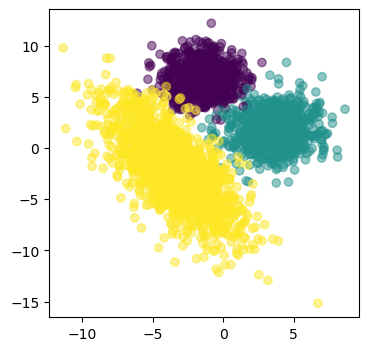

In [214]:
# Сгенерируем датасет
n_samples = 1500
dataset = datasets.make_blobs(n_samples = n_samples, centers = 2, center_box = (-7.0, 7.5),
                              cluster_std = [1.4, 1.7],
                              random_state = 42)
X_2, _ = datasets.make_blobs(n_samples = n_samples, random_state = 170, centers = [[-4, -3]], cluster_std = [1.9])
transformation = [[1.2, -0.8], [-0.4, 1.7]]
X_2 = np.dot(X_2, transformation)
X, y = np.concatenate((dataset[0], X_2)), np.concatenate((dataset[1], np.array([2] * len(X_2))))

# Визуализируем датасет
plt.rcParams['figure.figsize'] = 4, 4
plt.scatter(X[:, 0], X[:, 1], c = y, alpha = 0.5)
plt.show()

Значение V-меры у модели DBSCAN с параметром eps=0.9: 0.77
Значение V-меры у модели DBSCAN с параметром eps=0.8: 0.71


Text(0.5, 1.0, 'dbscan (eps=0.8), V-мера: 0.71')

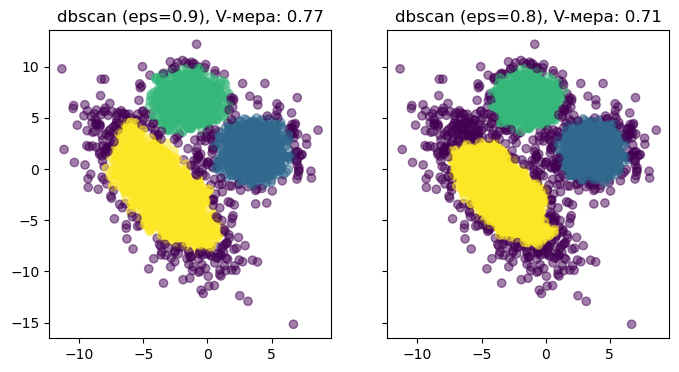

In [215]:
dbscan_1 = DBSCAN(eps = 0.9, min_samples = 35).fit(X)
dbscan_2 = DBSCAN(eps = 0.8, min_samples = 35).fit(X)

print(f'Значение V-меры у модели DBSCAN с параметром eps=0.9: {v_measure_score(labels_true = y, labels_pred = dbscan_1.labels_):.2f}')
print(f'Значение V-меры у модели DBSCAN с параметром eps=0.8: {v_measure_score(y, dbscan_2.labels_):.2f}')

f, (ax1, ax2) = plt.subplots(1, 2, sharey = True, figsize = (8, 4))
ax1.scatter(X[:, 0], X[:, 1], c = dbscan_1.labels_, alpha = 0.5)
ax2.scatter(X[:, 0], X[:, 1], c = dbscan_2.labels_, alpha = 0.5)
ax1.set_title(f'dbscan (eps=0.9), V-мера: {v_measure_score(labels_true = y, labels_pred = dbscan_1.labels_):.2f}')
ax2.set_title(f'dbscan (eps=0.8), V-мера: {v_measure_score(labels_true = y, labels_pred = dbscan_2.labels_):.2f}')

**Особенность алгоритма DBSCAN заключается в том, что помимо кластеризации этот алгоритм успешно находит выбросы в данных**   
- Посмотрим на качество кластеризации без учёта таких объектов.   
- Посчитаем значение v-меры (для модели dbscan_1) только для основных и граничных объектов выборки, то есть для объектов, которые не являются выбросами.

In [277]:
# Подсчитаем количество элементов в каждом из кластеров
# list(np.unique(dbscan_1.labels_, return_counts = True))
claster, counts = np.unique(dbscan_1.labels_, return_counts = True)
display(dict(zip(claster, counts)))

# Исключим выбросы и посчитаем v-меру
df = pd.DataFrame({'y': y, 'labels': dbscan_1.labels_})
df = df[df.labels != -1]
y_new = df.values[:, 0]
labels_new = df.values[:, 1]

v_measure = v_measure_score(y_new, labels_new)
print(f'Модель dbscan_1. Значение v-меры для основных и граничных объектов выборки: {v_measure:.3}')

{-1: 368, 0: 656, 1: 721, 2: 1255}

Модель dbscan_1. Значение v-меры для основных и граничных объектов выборки: 0.967


**Проверим, повлияет ли предобработка данных на результат кластеризации. Обучим две модели AgglomerativeClustering (1. На признаках исходного датасета; 2. На предварительно нормализованных признаках). Посчитаем v-меру для получившихся результатов.**

**Будем использовать два метода нормализации данных:**
- MinMax нормализация — приведение данных к масштабу между 0 и 1.
- Стандартная нормализация — данные имеют среднее 0 и стандартное отклонение 1.

In [21]:
# X_original = X.copy()
ag_original = AgglomerativeClustering(n_clusters = 3).fit(X_original).labels_
print(f'Значение V-меры на ненормализованных данных: {v_measure_score(labels_true = y, labels_pred = ag_original):.2f}')

X_standard = StandardScaler().fit_transform(X_original)
AgCl_standard = AgglomerativeClustering(n_clusters = 3).fit(X_standard).labels_
print(f'Значение V-меры после проведения стандартной нормализации: {v_measure_score(y, AgCl_standard):.2f}')

X_minmax = MinMaxScaler().fit_transform(X_original)
AgCl_minmax = AgglomerativeClustering(n_clusters = 3).fit(X_minmax).labels_
print(f'Значение V-меры после проведения MinMax нормализации: {v_measure_score(y, AgCl_minmax):.2f}')

Значение V-меры на ненормализованных данных: 0.70
Значение V-меры после проведения стандартной нормализации: 0.91
Значение V-меры после проведения MinMax нормализации: 0.89


# 3. Кластеризация текстов

In [42]:
# Будем работать с 4 категориями новостей 
categories = ['rec.sport.hockey',       # хоккей
              'talk.politics.mideast',  # политические новости о Ближнем Востоке
              'comp.graphics',          # компьютерная графика
              'sci.crypt']              # криптография
              

# Скачиваем набор данных
dataset = fetch_20newsgroups(subset = 'all', categories = categories,
                             shuffle = True, random_state = 42)

print("%d документов" % len(dataset.data))
print("%d категории" % len(dataset.target_names))

# Записываем значения категорий для каждой новости
labels = dataset.target
display(np.unique(labels, return_counts = True))

3903 документов
4 категории


(array([0, 1, 2, 3], dtype=int64), array([973, 999, 991, 940], dtype=int64))

#### Предобработка данных

In [43]:
# Исходный набор данных, первые 10 примеров
for i in range(10):
    print(dataset.data[i], end = '\n' + '*' * 50 + '\n\n')

From: c5ff@jupiter.sun.csd.unb.ca (COOK  Charlie)
Subject: NHL Summary parse results for games played Mon, April 19, 1993
Organization: University of New Brunswick
Lines: 79

Toronto                          1 1 1--3
Detroit                          1 4 1--6
First period
     1, Detroit, Yzerman 1 (Gallant, Ciccarelli) 4:48.
     2, Toronto, Cullen 1 (Clark, Gill) 10:44.
Second period
     3, Detroit, Sheppard 1 (Probert, Coffey) pp, 5:04.
     4, Detroit, Burr 1 (Racine) sh, 6:42.
     5, Detroit, Chiasson 1 (Coffey) pp,11:00.
     6, Detroit, Howe 1 (Yzerman, Drake) 14:46.
     7, Toronto, Gilmour 1 (Borschevsky, Ellett) pp, 19:59.
Third period
     8, Detroit, Racine 1 (Primeau, Drake) 5:10.
     9, Toronto, Lefebvre 1 (Cullen, Pearson) 7:45.

Detroit: 6    Power play: 6-2   Special goals:  pp: 2  sh: 1  Total: 3
Scorer            G    A   Pts
---------------  ---  ---  ---
Burr               1    0    1
Chiasson           1    0    1
Ciccarelli         0    1    1
Coffey           

In [44]:
# Создаём объект, который будет токенизировать данные
analyzer = CountVectorizer(stop_words = 'english').build_analyzer()

# Токенизируем наш набор данных
docs = []
for document in dataset.data:
    docs.append(analyzer(document.replace('_', '')))

# И посмотрим 10 первых примеров
for i in range(10):
    print(docs[i], end = '\n\n')

['c5ff', 'jupiter', 'sun', 'csd', 'unb', 'ca', 'cook', 'charlie', 'subject', 'nhl', 'summary', 'parse', 'results', 'games', 'played', 'mon', 'april', '19', '1993', 'organization', 'university', 'new', 'brunswick', 'lines', '79', 'toronto', 'detroit', 'period', 'detroit', 'yzerman', 'gallant', 'ciccarelli', '48', 'toronto', 'cullen', 'clark', 'gill', '10', '44', 'second', 'period', 'detroit', 'sheppard', 'probert', 'coffey', 'pp', '04', 'detroit', 'burr', 'racine', 'sh', '42', 'detroit', 'chiasson', 'coffey', 'pp', '11', '00', 'detroit', 'howe', 'yzerman', 'drake', '14', '46', 'toronto', 'gilmour', 'borschevsky', 'ellett', 'pp', '19', '59', 'period', 'detroit', 'racine', 'primeau', 'drake', '10', 'toronto', 'lefebvre', 'cullen', 'pearson', '45', 'detroit', 'power', 'play', 'special', 'goals', 'pp', 'sh', 'total', 'scorer', 'pts', 'burr', 'chiasson', 'ciccarelli', 'coffey', 'drake', 'gallant', 'howe', 'primeau', 'probert', 'racine', 'sheppard', 'yzerman', 'toronto', 'power', 'play', 'sco

In [45]:
# Проверим, что число документов осталось прежним
len(docs)

3903

### Векторизация текстов

In [46]:
# Установка пакета gensim
# !pip install -U gensim

При работе в Google Colab обязательно нужно запустить код из ячейки выше, несмотря на то, что в Google Colab gensim уже предустановлен.   
Так gensim обновится до последней версии. На данный момент в Google Colab уставнолена одна из прошлых версий модуля gensim, и поэтому на ней код ниже может не работать.

In [47]:
from gensim.models import Word2Vec

# Обучаем модель векторайзера на наборе данных
# На выходе получаем вектор признаков для каждого слова
model = Word2Vec(docs, min_count=20, vector_size=50) #Создаем векторы только для слов, кот. встречаются >20 раз во всех текстах
                                                     #Кодируем каждое слово 50-ю числами

# Наивный подход к созданию единого эмбеддинга для документа – средний эмбеддинг по словам
def doc_vectorizer(doc, model):
    doc_vector = []
    num_words = 0
    for word in doc:
        try:
            if num_words == 0:
                doc_vector = model.wv[word]
            else:
                doc_vector = np.add(doc_vector, model.wv[word])
            num_words += 1
        except:
            pass     
    return np.asarray(doc_vector) / num_words

# Составляем эмбеддинги для наших документов
X = []
for doc in docs:
    X.append(doc_vectorizer(doc, model))

In [48]:
# Как выглядят первые 10 документов после векторизации 
X[:10]

[array([-1.6709945 , -0.12724797,  0.71310663,  0.9385242 ,  0.21043022,
         0.0617153 ,  0.9840518 ,  0.718078  , -0.9626773 , -0.03893413,
        -0.19794479, -0.72984934, -0.5279928 ,  0.33071658,  0.09305495,
        -0.16380283, -0.21920769, -0.14228794, -0.1408584 , -0.46448925,
        -0.08496212, -0.00300858,  1.0548723 , -0.6481473 ,  0.17087553,
         0.25729114, -0.88194853, -0.08473802, -0.3615699 , -0.65058535,
        -0.11595254,  0.33939615,  0.2687616 ,  0.47327736, -1.2410072 ,
        -0.12422585, -0.313948  , -0.1848656 ,  0.5960792 , -0.8734978 ,
         0.5189051 , -0.46887743, -0.47284213,  0.03740775,  0.38150615,
         0.39729118, -0.5588993 , -0.9637435 , -0.38535783, -0.05173219],
       dtype=float32),
 array([-1.2625104 , -0.14724629,  0.26127917,  0.5490148 , -0.1632632 ,
        -0.37190512,  0.7214267 ,  0.6205551 , -0.72835535, -0.13776694,
        -0.46581358, -0.7165022 , -0.49608356,  0.09193995, -0.33284637,
        -0.27042213,  0.075

In [49]:
# Проверим размер вектора для документа
print(np.asarray(X).shape)

(3903, 50)


In [46]:
# t-SNE – метод понижения размерности
from sklearn.manifold import TSNE

# Создаём объект для выполнения t-SNE
tsne = TSNE(n_components = 2, random_state = 0)

# Преобразуем данные, понизив размерность с 50 до 2
X = tsne.fit_transform(X)

print(np.asarray(X).shape)

(3903, 2)


### Кластеризация

In [47]:
# Создаем KMeans кластеризатор. Обучаем его на подготовленных данных 
kmeans = KMeans(n_clusters = 4)
kmeans.fit(X)

KMeans(n_clusters=4)

In [48]:
# Получаем предсказанные кластеры
y_pred = kmeans.labels_.astype(int)
print ("Координаты центроидов:\n", kmeans.cluster_centers_)

Координаты центроидов:
 [[-38.87896    -2.173376 ]
 [ -3.450925  -36.380093 ]
 [ 53.238636    2.5351686]
 [ -7.763234   45.813457 ]]


In [49]:
# Метрики
print ("Коэффициент силуэта: %0.3f" % metrics.silhouette_score(X, y_pred, metric = 'euclidean'))
print("Однородность: %0.3f" % metrics.homogeneity_score(labels, y_pred))
print("Полнота: %0.3f" % metrics.completeness_score(labels, y_pred))
print("V-мера: %0.3f" % metrics.v_measure_score(labels, y_pred))

Коэффициент силуэта: 0.507
Однородность: 0.773
Полнота: 0.775
V-мера: 0.774


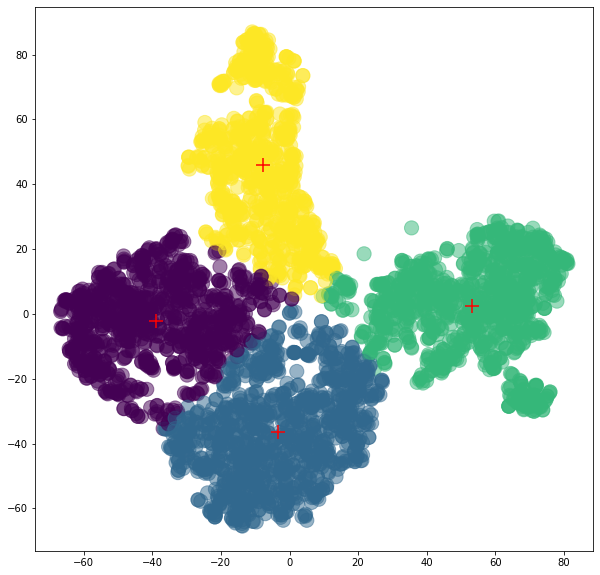

In [50]:
# Графики полученных кластеров
plt.rcParams['figure.figsize'] = 10, 10
plt.scatter(X[:, 0], X[:, 1], c = y_pred, s = 200, alpha = .5)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c = 'red', s = 200, marker = '+')
plt.show()

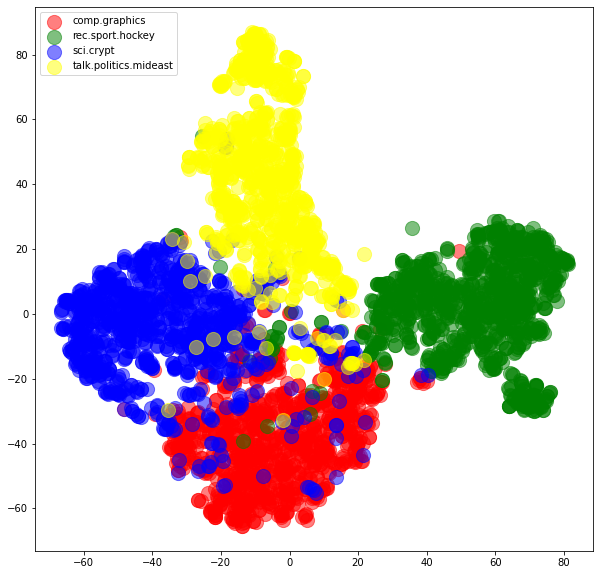

In [51]:
# Построим график истинных классов
colors = ("red", "green", "blue", "yellow")

for i in range(4):
    plt.scatter(X[labels == i][:, 0], X[labels == i][:, 1], \
                s = 200, alpha = .5, c = colors[i], label = dataset.target_names[i])
    plt.legend(loc = 2)

plt.show()

- Новости про криптографию и компьютерную графику немного пересекаются, что логично.   
- В данном случае kmeans довольно хорошо справился с работой, классы четко разделены.   